# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'CF',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_058  A0A075B6I6       17.356
Sample_201  P84157-2         12.430
Sample_135  Q9UQM7           16.676
Sample_077  Q14126           14.951
Sample_167  Q16581           16.677
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_059  Q7Z794                     15.422
Sample_100  Q12794;Q12794-2;Q12794-7   17.558
Sample_178  Q7L0X0                     15.902
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.625
            A0A075B6Q5                 12.870
            A0A075B6R2                 12.220
            A0A075B6S5                 12.145
            A0A087WSY4                 12.357
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.762
            Q9UI40;Q9UI40-2            13.981
            Q9UIW2                     12.220
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.847
            Q9UP79                     11.736
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.487,15.050,16.842,19.863,16.285,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,15.999,19.067,...,15.528,15.576,14.354,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.779,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.710,17.705,17.039,15.036,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.362,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.627,15.345,17.084,18.708,14.249,19.433,12.340,11.092
Sample_207,15.739,16.877,15.469,16.898,14.831,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.625,...,16.012,15.178,12.882,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.456,19.067,16.188,...,15.528,15.576,11.165,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.648,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.387,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.224,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.818,15.345,17.084,18.708,14.249,19.433,13.420,12.056
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 368.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.83it/s]

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.43it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.97it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.71it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.00it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.79it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.70it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.87it/s]

100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.01it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.21it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.52it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.30it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.51it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.61it/s]

100%|██████████| 8/8 [00:03<00:00,  2.59it/s]

100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.79it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.91it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.96it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.61it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.59it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.25it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.48it/s]

 30%|███       | 3/10 [00:00<00:01,  4.06it/s]

 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.19it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.96it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.84it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.51it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.59it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.53it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.74it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.31it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.25it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.26it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.96it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.06it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.18it/s]

100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

100%|██████████| 11/11 [00:03<00:00,  3.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.32it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.14it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.54it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.12it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.97it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.83it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.86it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.50it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.53it/s]

100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.33it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.60it/s]

 31%|███       | 4/13 [00:00<00:02,  4.04it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.70it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.52it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.44it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.01it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.91it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.08it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.21it/s]

100%|██████████| 13/13 [00:03<00:00,  2.98it/s]

100%|██████████| 13/13 [00:03<00:00,  3.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.41it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.20it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.29it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.53it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.14it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.46it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.49it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.38it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.31it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.42it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.41it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.37it/s]

100%|██████████| 14/14 [00:03<00:00,  3.27it/s]

100%|██████████| 14/14 [00:03<00:00,  3.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.18it/s]

 20%|██        | 3/15 [00:00<00:02,  4.86it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.30it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.06it/s]

 40%|████      | 6/15 [00:01<00:02,  3.89it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.55it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.69it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.65it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.66it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.65it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.85it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.78it/s]

100%|██████████| 15/15 [00:03<00:00,  3.74it/s]

100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.014          0.650 0.423       0.091   
2             0.006 0.006      0.078 0.036          0.616 0.145       0.451   
3             0.006 0.005      0.089 0.035          0.804 0.082       0.732   
4             0.004 0.002      0.056 0.024          0.793 0.081       0.772   
5             0.004 0.003      0.055 0.021          0.800 0.089       0.802   
6             0.005 0.004      0.065 0.024          0.800 0.091       0.806   
7             0.004 0.004      0.049 0.013          0.813 0.087       0.812   
8             0.006 0.006      0.080 0.032          0.808 0.088       0.804   
9             0.006 0.004      0.060 0.019          0.856 0.080       0.820   
10            0.004 0.000      0.046 0.008          0.854 0.086       0.819   
11            0.003 0.001      0.034 0.009          0.850 0.073       0.824   
12            0.004 0.002      0.047 0.011          0.845 0.077       0.828   
13            0.004 0.002      0.049 0.007          0.841 0.075       0.819   
14            0.004 0.001      0.049 0.007          0.837 0.076       0.819   
15            0.004 0.002      0.045 0.007          0.842 0.075       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.153 0.127                  0.538 0.039        0.851   
2          0.112   0.510 0.100                  0.615 0.070        0.694   
3          0.094   0.762 0.071                  0.799 0.056        0.911   
4          0.111   0.777 0.075                  0.811 0.062        0.914   
5          0.115   0.795 0.077                  0.826 0.064        0.917   
6          0.114   0.797 0.078                  0.827 0.065        0.915   
7          0.101   0.808 0.074                  0.836 0.062        0.916   
8          0.099   0.802 0.072                  0.830 0.061        0.914   
9          0.088   0.833 0.065                  0.858 0.054        0.929   
10         0.091   0.832 0.067                  0.856 0.056        0.927   
11         0.089   0.834 0.063                  0.858 0.053        0.930   
12         0.096   0.833 0.072                  0.858 0.061        0.928   
13         0.095   0.826 0.069                  0.852 0.058        0.927   
14         0.095   0.824 0.067                  0.850 0.057        0.926   
15         0.093   0.827 0.069                  0.852 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.090        210.000 0.000  
2          0.087                  0.648 0.101        210.000 0.000  
3          0.042                  0.896 0.045        210.000 0.000  
4          0.042                  0.897 0.049        210.000 0.000  
5          0.042                  0.903 0.047        210.000 0.000  
6          0.043                  0.902 0.047        210.000 0.000  
7          0.044                  0.904 0.047        210.000 0.000  
8          0.044                  0.902 0.047        210.000 0.000  
9          0.042                  0.921 0.043        210.000 0.000  
10         0.044                  0.915 0.049        210.000 0.000  
11         0.045                  0.919 0.048        210.000 0.000  
12         0.045                  0.917 0.047        210.000 0.000  
13         0.045                  0.915 0.048        210.000 0.000  
14         0.045                  0.914 0.047        210.000 0.000  
15         0.043                  0.911 0.047 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 449.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.82it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.89it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.43it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.60it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.20it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.70it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.60it/s]

100%|██████████| 7/7 [00:01<00:00,  3.37it/s]

100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.08it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.88it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.12it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.87it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.66it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.62it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.67it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.93it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.42it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.57it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.10it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.82it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.72it/s]

100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.23it/s]

 40%|████      | 4/10 [00:00<00:00,  7.09it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.55it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.21it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.04it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.95it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.83it/s]

100%|██████████| 10/10 [00:01<00:00,  5.84it/s]

100%|██████████| 10/10 [00:01<00:00,  6.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.32it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.12it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.55it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.27it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.05it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.90it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.84it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.78it/s]

100%|██████████| 11/11 [00:01<00:00,  5.75it/s]

100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.18it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.11it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.60it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.29it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.02it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.88it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.78it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.76it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.79it/s]

100%|██████████| 12/12 [00:01<00:00,  5.80it/s]

100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.37it/s]

 31%|███       | 4/13 [00:00<00:01,  7.16it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.60it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.26it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.03it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.87it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.80it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.75it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.70it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.69it/s]

100%|██████████| 13/13 [00:02<00:00,  5.67it/s]

100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.31it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.10it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.55it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.24it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.04it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.94it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.81it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.79it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.72it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.77it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.71it/s]

100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.43it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.07it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.57it/s]

 40%|████      | 6/15 [00:00<00:01,  6.27it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.08it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.00it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.84it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.75it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.67it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.69it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.68it/s]

100%|██████████| 15/15 [00:02<00:00,  5.72it/s]

100%|██████████| 15/15 [00:02<00:00,  6.06it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.008          0.000 0.000       0.000   
2             0.003 0.001      0.041 0.011          0.754 0.090       0.610   
3             0.003 0.001      0.039 0.014          0.763 0.104       0.671   
4             0.004 0.003      0.049 0.023          0.779 0.099       0.704   
5             0.003 0.001      0.039 0.008          0.767 0.094       0.698   
6             0.002 0.000      0.029 0.007          0.788 0.090       0.722   
7             0.004 0.000      0.043 0.002          0.801 0.084       0.728   
8             0.003 0.001      0.035 0.006          0.792 0.090       0.759   
9             0.002 0.000      0.027 0.000          0.816 0.091       0.750   
10            0.002 0.000      0.027 0.000          0.826 0.089       0.791   
11            0.002 0.000      0.027 0.000          0.827 0.085       0.791   
12            0.002 0.000      0.027 0.000          0.827 0.084       0.794   
13            0.002 0.000      0.026 0.000          0.829 0.087       0.796   
14            0.002 0.000      0.027 0.000          0.855 0.084       0.815   
15            0.002 0.000      0.027 0.000          0.853 0.083       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.859   
2          0.106   0.668 0.079                  0.730 0.056        0.788   
3          0.118   0.706 0.083                  0.756 0.060        0.864   
4          0.112   0.733 0.079                  0.776 0.059        0.865   
5          0.115   0.724 0.080                  0.769 0.059        0.863   
6          0.133   0.745 0.084                  0.787 0.064        0.880   
7          0.125   0.756 0.082                  0.796 0.062        0.882   
8          0.120   0.768 0.075                  0.804 0.062        0.887   
9          0.126   0.775 0.086                  0.812 0.068        0.900   
10         0.109   0.803 0.077                  0.833 0.064        0.905   
11         0.098   0.805 0.069                  0.834 0.058        0.923   
12         0.100   0.805 0.070                  0.835 0.058        0.921   
13         0.107   0.807 0.072                  0.836 0.060        0.924   
14         0.098   0.831 0.071                  0.856 0.059        0.927   
15         0.095   0.828 0.066                  0.853 0.056        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.830 0.087        210.000 0.000  
2          0.071                  0.757 0.088        210.000 0.000  
3          0.050                  0.824 0.074        210.000 0.000  
4          0.050                  0.828 0.074        210.000 0.000  
5          0.048                  0.825 0.072        210.000 0.000  
6          0.048                  0.844 0.071        210.000 0.000  
7          0.047                  0.846 0.070        210.000 0.000  
8          0.049                  0.844 0.074        210.000 0.000  
9          0.053                  0.863 0.076        210.000 0.000  
10         0.051                  0.871 0.070        210.000 0.000  
11         0.048                  0.899 0.064        210.000 0.000  
12         0.047                  0.897 0.064        210.000 0.000  
13         0.045                  0.899 0.062        210.000 0.000  
14         0.046                  0.904 0.062        210.000 0.000  
15         0.044                  0.903 0.059 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1348.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 55.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 41.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 36.80it/s]

100%|██████████| 4/4 [00:00<00:00, 36.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 35.13it/s]

100%|██████████| 5/5 [00:00<00:00, 32.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 36.39it/s]

100%|██████████| 6/6 [00:00<00:00, 32.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 38.08it/s]

100%|██████████| 7/7 [00:00<00:00, 32.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 38.33it/s]

100%|██████████| 8/8 [00:00<00:00, 30.74it/s]

100%|██████████| 8/8 [00:00<00:00, 31.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 38.24it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 32.09it/s]

100%|██████████| 9/9 [00:00<00:00, 32.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 36.82it/s]

 80%|████████  | 8/10 [00:00<00:00, 30.37it/s]

100%|██████████| 10/10 [00:00<00:00, 30.43it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 36.63it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 30.69it/s]

100%|██████████| 11/11 [00:00<00:00, 30.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 37.78it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 29.14it/s]

100%|██████████| 12/12 [00:00<00:00, 27.85it/s]

100%|██████████| 12/12 [00:00<00:00, 28.78it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 36.62it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 30.72it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 28.65it/s]

100%|██████████| 13/13 [00:00<00:00, 29.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 36.82it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.76it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.35it/s]

100%|██████████| 14/14 [00:00<00:00, 29.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 37.73it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.79it/s]

 80%|████████  | 12/15 [00:00<00:00, 29.37it/s]

100%|██████████| 15/15 [00:00<00:00, 28.64it/s]

100%|██████████| 15/15 [00:00<00:00, 29.57it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.027 0.001          0.626 0.122       0.456   
3             0.002 0.000      0.027 0.001          0.632 0.102       0.499   
4             0.002 0.000      0.027 0.000          0.706 0.113       0.594   
5             0.002 0.000      0.026 0.000          0.705 0.093       0.591   
6             0.002 0.000      0.027 0.000          0.710 0.100       0.590   
7             0.002 0.000      0.027 0.000          0.722 0.093       0.618   
8             0.002 0.000      0.027 0.000          0.731 0.086       0.638   
9             0.002 0.000      0.026 0.000          0.720 0.085       0.639   
10            0.002 0.000      0.027 0.000          0.676 0.075       0.646   
11            0.002 0.000      0.027 0.000          0.676 0.079       0.641   
12            0.002 0.000      0.027 0.000          0.686 0.077       0.662   
13            0.002 0.000      0.027 0.000          0.691 0.078       0.667   
14            0.002 0.000      0.027 0.000          0.721 0.073       0.690   
15            0.002 0.000      0.027 0.000          0.722 0.086       0.668   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.721   
2          0.096   0.521 0.087                  0.624 0.065        0.705   
3          0.112   0.549 0.087                  0.640 0.060        0.718   
4          0.116   0.640 0.099                  0.706 0.073        0.777   
5          0.113   0.637 0.089                  0.704 0.064        0.776   
6          0.113   0.638 0.092                  0.706 0.067        0.781   
7          0.122   0.659 0.094                  0.721 0.068        0.818   
8          0.127   0.673 0.090                  0.731 0.065        0.820   
9          0.121   0.670 0.086                  0.727 0.064        0.816   
10         0.127   0.654 0.083                  0.709 0.062        0.817   
11         0.125   0.652 0.086                  0.708 0.066        0.817   
12         0.123   0.668 0.085                  0.720 0.066        0.822   
13         0.124   0.672 0.084                  0.723 0.064        0.820   
14         0.116   0.700 0.082                  0.747 0.062        0.843   
15         0.123   0.687 0.091                  0.739 0.070        0.841   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.677 0.081        210.000 0.000  
2          0.075                  0.640 0.093        210.000 0.000  
3          0.074                  0.645 0.091        210.000 0.000  
4          0.062                  0.719 0.079        210.000 0.000  
5          0.062                  0.721 0.076        210.000 0.000  
6          0.067                  0.736 0.081        210.000 0.000  
7          0.060                  0.759 0.075        210.000 0.000  
8          0.062                  0.766 0.073        210.000 0.000  
9          0.065                  0.765 0.076        210.000 0.000  
10         0.063                  0.769 0.074        210.000 0.000  
11         0.064                  0.771 0.077        210.000 0.000  
12         0.061                  0.774 0.077        210.000 0.000  
13         0.059                  0.769 0.077        210.000 0.000  
14         0.054                  0.793 0.072        210.000 0.000  
15         0.055                  0.793 0.069 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,4,13
score_time,3,4,8
test_precision,9,14,8
test_recall,12,14,14
test_f1,11,14,14
test_balanced_accuracy,11,14,14
test_roc_auc,11,14,14
test_average_precision,9,14,14
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.38it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.19it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.66it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.34it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.21it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.12it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.95it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.92it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.80it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.82it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.79it/s]

100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

100%|██████████| 14/14 [00:02<00:00,  6.17it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 36.13it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.19it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.08it/s]

100%|██████████| 14/14 [00:00<00:00, 29.30it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.86it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.23it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.59it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.19it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.92it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.87it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.74it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.74it/s]

100%|██████████| 11/11 [00:01<00:00,  6.64it/s]

100%|██████████| 11/11 [00:01<00:00,  7.15it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


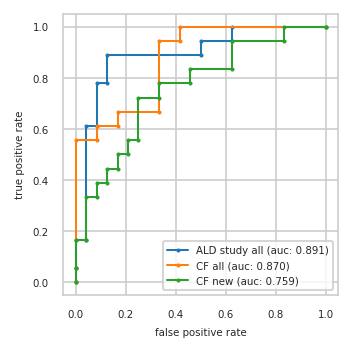

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.167  0.000 0.556  0.000 0.167
3          0.042 0.167  0.083 0.556  0.042 0.167
4          0.042 0.611  0.083 0.611  0.042 0.333
5          0.083 0.611  0.167 0.611  0.083 0.333
6          0.083 0.778  0.167 0.667  0.083 0.389
7          0.125 0.778  0.333 0.667  0.125 0.389
8          0.125 0.889  0.333 0.944  0.125 0.444
9          0.500 0.889  0.417 0.944  0.167 0.444
10         0.500 0.944  0.417 1.000  0.167 0.500
11         0.625 0.944  1.000 1.000  0.208 0.500
12         0.625 1.000    NaN   NaN  0.208 0.556
13         1.000 1.000    NaN   NaN  0.250 0.556
14           NaN   NaN    NaN   NaN  0.250 0.722
15           NaN   NaN    NaN   NaN  0.333 0.722
16           NaN   NaN    NaN   NaN  0.333 0.778
17           NaN   NaN    NaN   NaN  0.458 0.778
18           NaN   NaN    NaN   NaN  0.458 0.833
19           NaN   NaN    NaN   NaN  0.625 0.833
20           NaN   NaN    NaN   NaN  0.625 0.944
21           NaN   NaN    NaN   NaN  0.833 0.944
22           NaN   NaN    NaN   NaN  0.833 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9P2E7;Q9P2E7-2,Q9BRA2,J3KSJ8;Q9UD71;Q9UD71-2
2,P01597;P04432,P08670,P51688
3,P61981,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
4,P04075,A0A0A0MRJ7;P12259,P31321
5,P14174,P63104,Q96GD0
6,P00338;P00338-3,C9JF17;P05090,A0A0J9YW36;Q9NZ72;Q9NZ72-2
7,Q02818,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,Q9Y2T3;Q9Y2T3-3,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


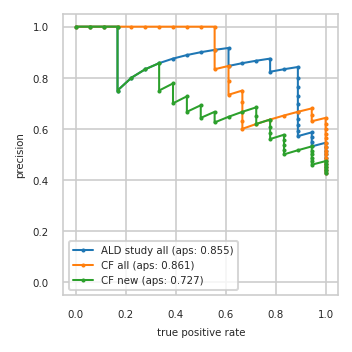

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.571 0.889     0.643 1.000     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.762 0.889     0.619 0.722     0.619 0.722
22         0.800 0.889     0.600 0.667     0.650 0.722
23         0.842 0.889     0.632 0.667     0.684 0.722
24         0.833 0.833     0.667 0.667     0.667 0.667
25         0.824 0.778     0.706 0.667     0.647 0.611
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     1.000 0.556     0.700 0.389
33         0.889 0.444     1.000 0.500     0.778 0.389
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.857 0.333
36         0.833 0.278     1.000 0.333     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


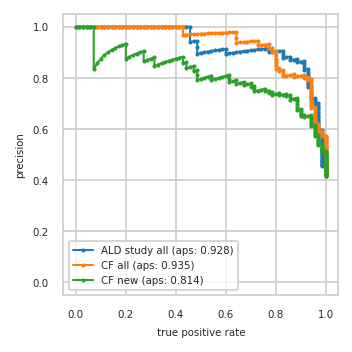

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


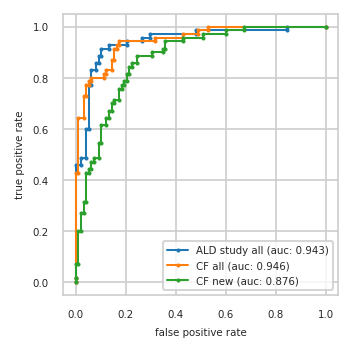

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

In [36]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}